In [ ]:
'''
 * Copyright (c) 2018 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Hybrid Evolutionary Programming (HEP)

## Constrained Optimization Problem

Consider the following constrained optimization problem:

$$
P : \min f(x) \quad \text{subject to} \quad g_i(x) \leq 0, \quad i = 1, \dots, r, \quad h_j(x) = 0, \quad j = 1, \dots, m
$$

where $ f $ and $ g_1, \dots, g_r $ are functions on $ \mathbb{R}^n $, and $ h_1, \dots, h_m $ are functions on $ \mathbb{R}^m $ for $ m \leq n $, and $ x = [x_1, \dots, x_n]^T \in \mathbb{R}^n $. The feasible solution to the optimization problem is a vector $ x $ that satisfies the inequality constraints $ g_i(x) \leq 0 $ and the equality constraints $ h_j(x) = 0 $.

### Feasibility and Cost Function

The vector $ x $ is feasible if it satisfies the constraints. The cost function is:

$$
\Phi_f(x) = f(x), \quad \text{if} \quad x \in F
$$

where $ F $ is the feasible region of the search space.

### Constraint Violation Measure

The constraint violation is measured as:

$$
\Phi_u(x) = \sum_{i=1}^{r} \max(0, g_i(x)) + \sum_{j=1}^{m} |h_j(x)|
$$

or alternatively,

$$
\Phi_u(x) = \sqrt{\sum_{i=1}^{r} (g_i(x))^2 + \sum_{j=1}^{m} (h_j(x))^2}
$$

### Total Evaluation Function

The total evaluation function $ \Phi(x) $ is a combination of the cost function and the penalty for constraint violations:

$$
\Phi(x) = \Phi_f(x) + s \Phi_u(x)
$$

where $ s $ is a positive penalty parameter for minimization or negative for maximization.

### Unconstrained Optimization

The original constrained optimization problem becomes an unconstrained optimization problem:

$$
\min \left\{ f(x) + s \Phi_u(x) \right\}
$$

## Hybrid Evolutionary Programming (HEP)

In Hybrid Evolutionary Programming (HEP), each individual is represented by a triplet of real-valued vectors:

$$
(x_i, \sigma_i, \eta_i)
$$

where:
- $ x_i = [x_i(1), \dots, x_i(n)]^T $ is the solution vector.
- $ \sigma_i $ and $ \eta_i $ are the corresponding strategy parameter vectors.

The mutation operators in HEP combine Gaussian and Cauchy mutations. The updates are as follows:

### Mutation for $ x_i $

$$
x_i^{(j)} = x_i^{(j)} + \sigma_i^{(j)} \left[ N_j(0, 1) + \beta_i^{(j)} C_j(0, 1) \right]
$$

where $ N_j(0, 1) $ is a standard Gaussian random variable and $ C_j(0, 1) $ is a standard Cauchy random variable.

### Mutation for $\eta_i $

The update for the mutation strategy parameter $ \eta_i $ is:

$$
\eta_i^{(j)} = \eta_i^{(j)} \exp\left( \tau N(0, 1) + \tau N_j(0, 1) \right)
$$

### Mutation for $ \sigma_i $

The update for the step size $ \sigma_i $ is:

$$
\sigma_i^{(j)} = \sigma_i^{(j)} \exp\left( \tau' N(0, 1) + \tau N_j(0, 1) \right)
$$

where $ \tau $ and $ \tau' $ are predefined constants that adjust the scaling of the mutations.

### Random Variables

For each mutation, the random variables are generated anew for each component $ j $ of the solution, ensuring diversity in the search process.

$$
N_j(0, 1), \quad C_j(0, 1) \quad \text{for each} \quad j = 1, \dots, n
$$


In [1]:
import numpy as np

# Define the fitness function (to be minimized)
def fitness_function(x):
    # Example: Sphere function (just for illustration purposes)
    return np.sum(x ** 2)

# Constraint functions (for illustration, we assume simple constraints)
def constraint_violations(x):
    # Example: simple constraint: x1 + x2 <= 1
    g = np.sum(x) - 1
    return max(0, g)

# Cauchy random variable generator
def cauchy_mutation(scale=1):
    return np.random.standard_cauchy() * scale

# Hybrid mutation using Gaussian + Cauchy
def hybrid_mutation(xi, sigma_i, eta_i, beta_i, tau, tau_prime):
    # Mutation of x using Gaussian and Cauchy distributions
    n = len(xi)
    mutated_xi = xi.copy()
    for j in range(n):
        gaussian_mutation = np.random.normal(0, 1)
        cauchy_mutation_value = cauchy_mutation(1)  # Scale is set to 1 by default
        mutated_xi[j] = xi[j] + sigma_i[j] * (gaussian_mutation + beta_i[j] * cauchy_mutation_value)

    # Update the strategy parameters (eta and sigma)
    mutated_eta_i = eta_i * np.exp(tau * np.random.normal(0, 1) + tau * np.random.normal(0, 1))
    mutated_sigma_i = sigma_i * np.exp(tau_prime * np.random.normal(0, 1) + tau * np.random.normal(0, 1))
    
    return mutated_xi, mutated_eta_i, mutated_sigma_i

# Evaluate the solution
def evaluate_solution(xi, fitness_func, s, constraint_func):
    fitness = fitness_func(xi)
    violations = constraint_func(xi)
    total_evaluation = fitness + s * violations
    return total_evaluation

# Tournament selection function
def tournament_selection(population, num_selected, fitness_func, s, constraint_func):
    # Sort individuals by their fitness evaluation
    evaluated_pop = [(ind, evaluate_solution(ind[0], fitness_func, s, constraint_func)) for ind in population]
    evaluated_pop.sort(key=lambda x: x[1])  # Sort by evaluation value (lower is better)
    return [ind[0] for ind in evaluated_pop[:num_selected]]  # Select the best `num_selected`

# Main HEP algorithm
def hybrid_evolutionary_programming(pop_size, dimensions, generations, tau=0.1, tau_prime=0.1, s=100):
    # Initialize population: (x, sigma, eta)
    population = []
    for _ in range(pop_size):
        xi = np.random.uniform(-5, 5, dimensions)  # Random solution within bounds
        sigma_i = np.ones(dimensions)  # Initial step size (sigma)
        eta_i = np.ones(dimensions)  # Initial strategy parameter (eta)
        population.append((xi, sigma_i, eta_i))
    
    # Evolution loop
    for generation in range(generations):
        # Create offspring
        offspring = []
        for xi, sigma_i, eta_i in population:
            beta_i = np.random.uniform(-1, 1, dimensions)  # Random beta values for mutation
            mutated_xi, mutated_eta_i, mutated_sigma_i = hybrid_mutation(xi, sigma_i, eta_i, beta_i, tau, tau_prime)
            offspring.append((mutated_xi, mutated_eta_i, mutated_sigma_i))
        
        # Combine population and offspring for selection
        combined_population = population + offspring
        
        # Select the best individuals based on fitness
        population = tournament_selection(combined_population, pop_size, fitness_function, s, constraint_violations)
    
    # Return the best solution found
    best_solution = min(population, key=lambda x: evaluate_solution(x[0], fitness_function, s, constraint_violations))
    return best_solution[0]

# Parameters
pop_size = 50
dimensions = 10
generations = 100

# Run the algorithm
best_solution = hybrid_evolutionary_programming(pop_size, dimensions, generations)

print("Best Solution Found: ", best_solution)


Best Solution Found:  [-0.56943654  0.43674593 -0.0275256  -0.59004377 -0.46608512  0.5866549
 -0.19459647 -0.35573592  0.59034697  0.30056266]


In [2]:
import random
import math

# Define the fitness function (to be minimized)
def fitness_function(x):
    # Example: Sphere function (just for illustration purposes)
    return sum(xi ** 2 for xi in x)

# Constraint functions (for illustration, we assume simple constraints)
def constraint_violations(x):
    # Example: simple constraint: x1 + x2 <= 1
    g = sum(x) - 1
    return max(0, g)

# Cauchy random variable generator
def cauchy_mutation(scale=1):
    return random.gauss(0, 1) / random.gauss(0, 1) * scale  # Using Cauchy distribution formula

# Hybrid mutation using Gaussian + Cauchy
def hybrid_mutation(xi, sigma_i, eta_i, beta_i, tau, tau_prime):
    n = len(xi)
    mutated_xi = []
    
    for j in range(n):
        # Gaussian mutation
        gaussian_mutation = random.gauss(0, 1)
        # Cauchy mutation
        cauchy_mutation_value = cauchy_mutation(1)  # Scale is set to 1 by default
        mutated_xi.append(xi[j] + sigma_i[j] * (gaussian_mutation + beta_i[j] * cauchy_mutation_value))

    # Update the strategy parameters (eta and sigma)
    mutated_eta_i = [eta * math.exp(tau * random.gauss(0, 1) + tau * random.gauss(0, 1)) for eta in eta_i]
    mutated_sigma_i = [sigma * math.exp(tau_prime * random.gauss(0, 1) + tau * random.gauss(0, 1)) for sigma in sigma_i]
    
    return mutated_xi, mutated_eta_i, mutated_sigma_i

# Evaluate the solution
def evaluate_solution(xi, fitness_func, s, constraint_func):
    fitness = fitness_func(xi)
    violations = constraint_func(xi)
    total_evaluation = fitness + s * violations
    return total_evaluation

# Tournament selection function
def tournament_selection(population, num_selected, fitness_func, s, constraint_func):
    # Sort individuals by their fitness evaluation
    evaluated_pop = [(ind, evaluate_solution(ind[0], fitness_func, s, constraint_func)) for ind in population]
    evaluated_pop.sort(key=lambda x: x[1])  # Sort by evaluation value (lower is better)
    return [ind[0] for ind in evaluated_pop[:num_selected]]  # Select the best `num_selected`

# Main HEP algorithm
def hybrid_evolutionary_programming(pop_size, dimensions, generations, tau=0.1, tau_prime=0.1, s=100):
    # Initialize population: (x, sigma, eta)
    population = []
    for _ in range(pop_size):
        xi = [random.uniform(-5, 5) for _ in range(dimensions)]  # Random solution within bounds
        sigma_i = [1.0 for _ in range(dimensions)]  # Initial step size (sigma)
        eta_i = [1.0 for _ in range(dimensions)]  # Initial strategy parameter (eta)
        population.append((xi, sigma_i, eta_i))
    
    # Evolution loop
    for generation in range(generations):
        # Create offspring
        offspring = []
        for xi, sigma_i, eta_i in population:
            beta_i = [random.uniform(-1, 1) for _ in range(dimensions)]  # Random beta values for mutation
            mutated_xi, mutated_eta_i, mutated_sigma_i = hybrid_mutation(xi, sigma_i, eta_i, beta_i, tau, tau_prime)
            offspring.append((mutated_xi, mutated_eta_i, mutated_sigma_i))
        
        # Combine population and offspring for selection
        combined_population = population + offspring
        
        # Select the best individuals based on fitness
        population = tournament_selection(combined_population, pop_size, fitness_function, s, constraint_violations)
    
    # Return the best solution found
    best_solution = min(population, key=lambda x: evaluate_solution(x[0], fitness_function, s, constraint_violations))
    return best_solution[0]

# Parameters
pop_size = 50
dimensions = 10
generations = 100

# Run the algorithm
best_solution = hybrid_evolutionary_programming(pop_size, dimensions, generations)

print("Best Solution Found: ", best_solution)


Best Solution Found:  [0.8250201243487028, 0.35175022965759983, -0.5598871448171308, 0.24311356406660026, -1.3860887192259739, 1.015767244494094, -0.14315574730889402, 0.4762672277798352, -0.5202986960339852, -0.5616552637414849]


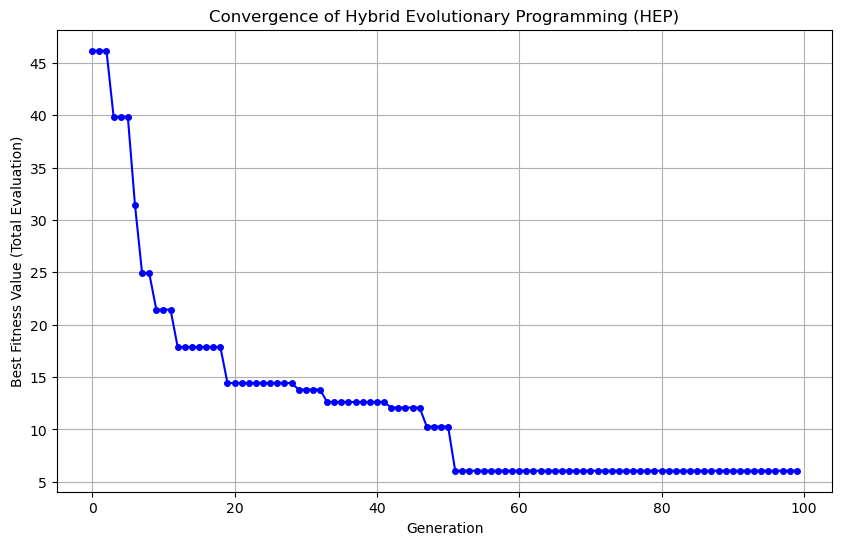

Best Solution Found:  [-0.8333903728297112, -0.2718663789950362, -0.01231373794128987, -1.5917648349925335, 0.1908139533554315, 0.3252458631652206, -0.9500054957654973, 0.8385407873871564, 0.6813130025711175, -0.7396152783966015]


In [3]:
import random
import math
import matplotlib.pyplot as plt

# Define the fitness function (to be minimized)
def fitness_function(x):
    return sum(xi ** 2 for xi in x)  # Example: Sphere function (for illustration)

# Constraint functions (for illustration, assume simple constraints)
def constraint_violations(x):
    g = sum(x) - 1  # Example: simple constraint: x1 + x2 <= 1
    return max(0, g)

# Cauchy random variable generator
def cauchy_mutation(scale=1):
    return random.gauss(0, 1) / random.gauss(0, 1) * scale  # Cauchy distribution formula

# Hybrid mutation using Gaussian + Cauchy
def hybrid_mutation(xi, sigma_i, eta_i, beta_i, tau, tau_prime):
    n = len(xi)
    mutated_xi = []
    
    for j in range(n):
        gaussian_mutation = random.gauss(0, 1)  # Gaussian mutation
        cauchy_mutation_value = cauchy_mutation(1)  # Cauchy mutation with scale 1
        mutated_xi.append(xi[j] + sigma_i[j] * (gaussian_mutation + beta_i[j] * cauchy_mutation_value))

    mutated_eta_i = [eta * math.exp(tau * random.gauss(0, 1) + tau * random.gauss(0, 1)) for eta in eta_i]
    mutated_sigma_i = [sigma * math.exp(tau_prime * random.gauss(0, 1) + tau * random.gauss(0, 1)) for sigma in sigma_i]
    
    return mutated_xi, mutated_eta_i, mutated_sigma_i

# Evaluate the solution
def evaluate_solution(xi, fitness_func, s, constraint_func):
    fitness = fitness_func(xi)
    violations = constraint_func(xi)
    total_evaluation = fitness + s * violations
    return total_evaluation

# Tournament selection function
def tournament_selection(population, num_selected, fitness_func, s, constraint_func):
    evaluated_pop = [(ind, evaluate_solution(ind[0], fitness_func, s, constraint_func)) for ind in population]
    evaluated_pop.sort(key=lambda x: x[1])  # Sort by evaluation value (lower is better)
    return [ind[0] for ind in evaluated_pop[:num_selected]]  # Select the best `num_selected`

# Main HEP algorithm with tracking for plotting
def hybrid_evolutionary_programming(pop_size, dimensions, generations, tau=0.1, tau_prime=0.1, s=100):
    population = []
    best_fitness_per_generation = []

    # Initialize population: (x, sigma, eta)
    for _ in range(pop_size):
        xi = [random.uniform(-5, 5) for _ in range(dimensions)]
        sigma_i = [1.0 for _ in range(dimensions)]
        eta_i = [1.0 for _ in range(dimensions)]
        population.append((xi, sigma_i, eta_i))
    
    for generation in range(generations):
        offspring = []
        for xi, sigma_i, eta_i in population:
            beta_i = [random.uniform(-1, 1) for _ in range(dimensions)]
            mutated_xi, mutated_eta_i, mutated_sigma_i = hybrid_mutation(xi, sigma_i, eta_i, beta_i, tau, tau_prime)
            offspring.append((mutated_xi, mutated_eta_i, mutated_sigma_i))

        # Combine population and offspring for selection
        combined_population = population + offspring
        population = tournament_selection(combined_population, pop_size, fitness_function, s, constraint_violations)
        
        # Track the best fitness value in the current population
        best_solution = min(population, key=lambda x: evaluate_solution(x[0], fitness_function, s, constraint_violations))
        best_fitness_per_generation.append(evaluate_solution(best_solution[0], fitness_function, s, constraint_violations))
    
    # Return the best solution found
    best_solution = min(population, key=lambda x: evaluate_solution(x[0], fitness_function, s, constraint_violations))
    return best_solution[0], best_fitness_per_generation

# Parameters
pop_size = 50
dimensions = 10
generations = 100

# Run the algorithm
best_solution, best_fitness_per_generation = hybrid_evolutionary_programming(pop_size, dimensions, generations)

# Plotting the convergence graph
plt.figure(figsize=(10, 6))
plt.plot(range(generations), best_fitness_per_generation, color='blue', marker='o', linestyle='-', markersize=4)
plt.title('Convergence of Hybrid Evolutionary Programming (HEP)')
plt.xlabel('Generation')
plt.ylabel('Best Fitness Value (Total Evaluation)')
plt.grid(True)
plt.show()

# Output the best solution found
print("Best Solution Found: ", best_solution)


## Classical Differential Evolution (DE)

Differential Evolution (DE) is a simple yet effective optimization algorithm introduced by Storn and Price in 1997. It is particularly effective for global optimization over continuous spaces and is capable of handling nonlinear, non-differentiable, and multimodal cost functions. The algorithm has the following key properties:

1. Ability to handle non-differentiable, nonlinear, and multimodal cost functions.
2. Parallelizability to cope with intensive computational cost functions.
3. Ease of use with few control parameters.
4. Good convergence properties, ensuring consistent convergence to the global minimum in independent trials.

## Differential Evolution Algorithm

Given a population of D-dimensional vectors $ p_G^i = [P_1^i, P_2^i, ..., P_D^i] $, where $ NP $ is the population size, the classical DE algorithm can be broken down into the following steps:

### Algorithm Steps:
1. **Initialization:**
   - The initial population $ p_0 = [P_0^1, ..., P_0^i] $ is generated randomly with a uniform probability distribution.

2. **While Loop:**
   - The loop continues while the best fitness value (BFV) is greater than the desired target value (VTR) and the number of function calls (NFC) is less than the maximum allowed (MAXNFC).

3. **Mutation:**
   - For each target vector $ p_G^i $, three distinct parents $ p_{i1}, p_{i2}, p_{i3} $ are selected randomly from the current population.
   - A mutant vector $ v_{G+1}^i $ is created by adding a weighted difference between two parent vectors:
   $$
   v_{G+1}^i = p_G^i + F \times (p_G^3 - p_G^2)
   $$
   where $ F > 0 $ is a constant mutation factor controlling the differential variation $ d_G = p_G^3 - p_G^2 $.

4. **Crossover:**
   - To increase diversity, crossover is applied to the mutant vector $ v_{G+1}^i $. Each element $ U_j^i $ of the trial vector $ u_{G+1}^i $ is selected from either the mutant vector $ v_{G+1}^i $ or the target vector $ p_G^i $ based on a random probability:
   $$
   U_j^i = 
   \begin{cases} 
   V_j^i & \text{if} \quad \text{rand}(0, 1) \leq CR \\
   P_j^i & \text{otherwise}
   \end{cases}
   $$
   where $ CR $ is the crossover rate and $ j_{\text{rand}} $ is a randomly chosen index to ensure diversity.

5. **Selection:**
   - The trial vector $ u_{G+1}^i $ is evaluated using the fitness function. If the fitness of the trial vector is better than the target vector, the trial vector becomes the next generation's vector:
   $
   p_{G+1}^i = 
   \begin{cases}
   u_{G+1}^i & \text{if} \quad f(u_{G+1}^i) < f(p_G^i) \\
   p_G^i & \text{otherwise}
   \end{cases}
   $

6. **Termination:**
   - The algorithm terminates when either the desired fitness value (VTR) is reached or the maximum number of function calls (MAXNFC) is exceeded.

### Pseudocode for Classical DE Algorithm:

$$
\text{1. Input: Population size NP, problem dimension D, mutation constant F, crossover rate Cr.}
$$
$
\text{2. Initialization: Generate random population } p_0 = [P_0^1, P_0^2, ..., P_0^i].
$
$
\text{3. While (BFV > VTR) and (NFC < MAXNFC):}
$
$
\text{4. For } i = 1 \text{ to } NP:
$
$
\quad \text{5. Select three parents } p_{i1}, p_{i2}, p_{i3} \text{ randomly from current population.}
$
$
\quad \text{6. Mutation: } v_{G+1}^i = p_G^i + F \times (p_G^3 - p_G^2).
$
$
\quad \text{7. Crossover: For each dimension j:}
$
$
\quad \quad \text{If rand(0,1) < Cr:}
$
$
\quad \quad \quad U_j^i = V_j^i
$
$
\quad \quad \text{Else:}
$
$
\quad \quad \quad U_j^i = P_j^i.
$
$
\quad \text{8. If } f(U_{i}) \leq f(p_G^i):
$
$
\quad \quad p_{G+1}^i = u_{G+1}^i
$
$$
\quad \text{Else:}
$$
$$
\quad \quad p_{G+1}^i = p_G^i.
$$
$$
\text{9. End For}
$$
$$
\text{10. Output: Best solution } p.
$$

### Summary of DE Operations:
1. **Mutation:** Introduces diversity by adding weighted differences between parent solutions.
2. **Crossover:** Combines the target and mutant vectors to create trial vectors.
3. **Selection:** Chooses the better solution (target or trial) for the next generation.

### Advantages of Differential Evolution:
- Simple and easy to implement.
- Requires very few control parameters.
- Robust in handling complex and multimodal optimization problems.

### Limitations:
- May require a large number of function evaluations for complex problems.
- Sensitive to the choice of mutation factor $ F $ and crossover rate $ CR $.


In [4]:
import random

# Define the objective function
def objective_function(x):
    # Example: Sphere function (simple objective for demonstration)
    return sum(xi**2 for xi in x)

# Differential Evolution (DE) Algorithm
def differential_evolution(NP, D, F, CR, MAXNFC, VTR):
    # Initialize population with random values
    population = [[random.uniform(-5, 5) for _ in range(D)] for _ in range(NP)]
    
    # Evaluate fitness of the initial population
    fitness = [objective_function(individual) for individual in population]
    
    # Initialize best fitness value
    BFV = min(fitness)
    
    # Iteration counter
    NFC = 0
    
    # Start evolutionary process
    while BFV > VTR and NFC < MAXNFC:
        # Create an empty list for the next generation
        next_population = []
        
        for i in range(NP):
            # Select three distinct random indices (parents)
            idxs = list(range(NP))
            idxs.remove(i)
            i1, i2, i3 = random.sample(idxs, 3)
            
            # Mutation: Create the mutant vector
            mutant = [population[i1][j] + F * (population[i3][j] - population[i2][j]) for j in range(D)]
            
            # Crossover: Create the trial vector
            trial = []
            for j in range(D):
                if random.random() < CR:
                    trial.append(mutant[j])
                else:
                    trial.append(population[i][j])
            
            # Selection: If trial vector is better, replace the target vector
            trial_fitness = objective_function(trial)
            NFC += 1
            
            if trial_fitness < fitness[i]:
                next_population.append(trial)
                fitness[i] = trial_fitness
            else:
                next_population.append(population[i])
        
        # Update the population for the next generation
        population = next_population
        
        # Update the best fitness value
        BFV = min(fitness)
        
    # Return the best solution found and its fitness
    best_solution = population[fitness.index(BFV)]
    return best_solution, BFV

# Example usage of Differential Evolution
NP = 20       # Population size
D = 10        # Dimension of the problem (number of variables)
F = 0.8       # Mutation factor
CR = 0.9      # Crossover rate
MAXNFC = 1000 # Maximum number of function calls
VTR = 1e-6    # Target value for stopping condition

best_solution, best_fitness = differential_evolution(NP, D, F, CR, MAXNFC, VTR)

print("Best solution found:", best_solution)
print("Best fitness:", best_fitness)


Best solution found: [-0.023569575509484575, 0.7831818823021217, 0.45377027978466283, -0.9890036383336565, -0.4925761777857227, 0.5165344312581188, 0.5451085711605248, -0.2049544983229169, -0.6830977996441927, 0.3059786831684239]
Best fitness: 3.2067994178738815


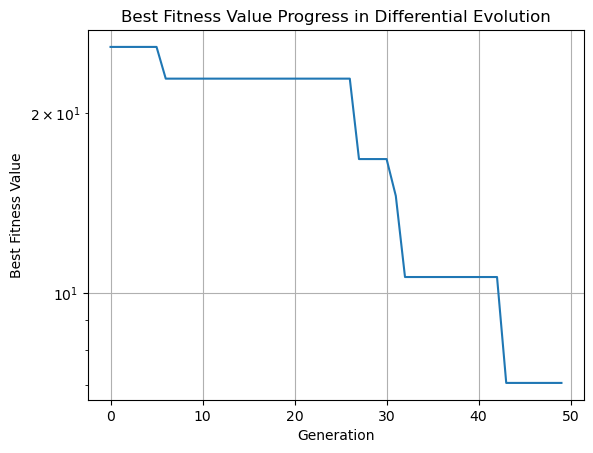

Best solution found: [0.6762339117680294, -0.43998853437012264, -0.8401558642679481, 0.05804257254542258, -0.6258665944144441, -0.4024021251539718, -0.10341856113994519, -0.2459983873890801, -1.054617464874877, 1.9909168608392174]
Best fitness: 7.06092804400542


In [5]:
import random
import matplotlib.pyplot as plt

# Define the objective function
def objective_function(x):
    # Example: Sphere function (simple objective for demonstration)
    return sum(xi**2 for xi in x)

# Differential Evolution (DE) Algorithm
def differential_evolution(NP, D, F, CR, MAXNFC, VTR):
    # Initialize population with random values
    population = [[random.uniform(-5, 5) for _ in range(D)] for _ in range(NP)]
    
    # Evaluate fitness of the initial population
    fitness = [objective_function(individual) for individual in population]
    
    # Initialize best fitness value
    BFV = min(fitness)
    
    # Iteration counter
    NFC = 0
    
    # To track the progress of the optimization
    best_fitness_progress = []
    
    # Start evolutionary process
    while BFV > VTR and NFC < MAXNFC:
        # Create an empty list for the next generation
        next_population = []
        
        for i in range(NP):
            # Select three distinct random indices (parents)
            idxs = list(range(NP))
            idxs.remove(i)
            i1, i2, i3 = random.sample(idxs, 3)
            
            # Mutation: Create the mutant vector
            mutant = [population[i1][j] + F * (population[i3][j] - population[i2][j]) for j in range(D)]
            
            # Crossover: Create the trial vector
            trial = []
            for j in range(D):
                if random.random() < CR:
                    trial.append(mutant[j])
                else:
                    trial.append(population[i][j])
            
            # Selection: If trial vector is better, replace the target vector
            trial_fitness = objective_function(trial)
            NFC += 1
            
            if trial_fitness < fitness[i]:
                next_population.append(trial)
                fitness[i] = trial_fitness
            else:
                next_population.append(population[i])
        
        # Update the population for the next generation
        population = next_population
        
        # Update the best fitness value
        BFV = min(fitness)
        
        # Track the best fitness progress
        best_fitness_progress.append(BFV)
    
    # Return the best solution found and its fitness
    best_solution = population[fitness.index(BFV)]
    return best_solution, BFV, best_fitness_progress

# Example usage of Differential Evolution
NP = 20       # Population size
D = 10        # Dimension of the problem (number of variables)
F = 0.8       # Mutation factor
CR = 0.9      # Crossover rate
MAXNFC = 1000 # Maximum number of function calls
VTR = 1e-6    # Target value for stopping condition

best_solution, best_fitness, best_fitness_progress = differential_evolution(NP, D, F, CR, MAXNFC, VTR)

# Plot the best fitness progress
plt.plot(best_fitness_progress)
plt.xlabel('Generation')
plt.ylabel('Best Fitness Value')
plt.title('Best Fitness Value Progress in Differential Evolution')
plt.yscale('log')  # Optional: log scale to better visualize convergence
plt.grid(True)
plt.show()

print("Best solution found:", best_solution)
print("Best fitness:", best_fitness)


## Differential Evolution Variants

Differential Evolution (DE) is a powerful optimization algorithm. There are several schemes and variants of DE, each with its own mutation strategies and applications. The classical DE and its variants include the following:

### Mutation Strategies

1. **Classical DE (DE/rand/1/bin)**:
   $$
   v_{i}^{G} = p_{r1}^{G} + F \cdot (p_{r2}^{G} - p_{r3}^{G})
   $$
   where $ p_{r1}^{G}, p_{r2}^{G}, p_{r3}^{G}$ are randomly selected vectors, and $ F $ is the scaling factor. This is the standard mutation strategy used in classical DE.

2. **DE with Best Vector (DE/best/1/bin)**:
   $$
   v_{i}^{G} = p_{best}^{G} + F \cdot (p_{r1}^{G} - p_{r2}^{G})
   $$
   In this strategy, $ p_{best}^{G} $ is the best vector in the current population, and the mutation vector is scaled based on the difference between two randomly selected vectors.

3. **DE with Two Mutations (DE/best/2/bin)**:
   $$
   v_{i}^{G} = p_{i}^{G} + F \cdot (p_{best}^{G} - p_{i}^{G}) + F \cdot (p_{r1}^{G} - p_{r2}^{G})
   $$
   This strategy incorporates both the best vector $ p_{best}^{G} $ and the difference between two randomly selected vectors.

4. **DE with Four Mutations (DE/best/2/exp)**:
   $$
   v_{i}^{G} = p_{best}^{G} + F \cdot (p_{r1}^{G} - p_{r2}^{G}) + F \cdot (p_{r3}^{G} - p_{r4}^{G})
   $$
   This variant uses a combination of the best vector and the difference between four randomly selected vectors.

### DE Notation

The notation **DE/a/b/c** defines the type of mutation and crossover strategy used:
- **a**: Specifies the vector that should be mutated. It can either be the best vector (best) or a randomly selected one (rand).
- **b**: The number of difference vectors used in the mutation strategy.
- **c**: The crossover scheme applied, either binary (bin) or exponential (exp).

### Popular Variants

1. **Neighborhood Search Differential Evolution (NSDE)**

   In NSDE, the mutation strategy is modified with a neighborhood search mechanism:
   $$
   v_{i}^{G+1} = p_{r1}^{G} + \delta \cdot d_{i}^{G} \quad \text{if } \text{rand}(0,1) < 0.5
   $$
   $$
   v_{i}^{G+1} = p_{r1}^{G} + F \cdot d_{i}^{G} \quad \text{otherwise}
   $$
   where $ d_{i}^{G} = p_{r2}^{G} - p_{r3}^{G} $, and $ \delta $ is a Cauchy random variable. This variant improves the performance of the DE algorithm by introducing Gaussian and Cauchy random variables into the mutation process.

2. **Self-Adaptive Differential Evolution (SaDE)**

   SaDE adapts two mutation strategies based on a probability $ p $ and self-adapts the parameters $ F $ (scaling factor) and $ CR $ (crossover rate):
   
   - **Mutation Strategy**:
     $$
     v_{i}^{G+1} = \begin{cases} 
     p_{r1}^{G} + F \cdot (p_{r2}^{G} - p_{r3}^{G}) & \text{with probability } p \\
     p_{best}^{G} + F \cdot (p_{r1}^{G} - p_{r2}^{G}) & \text{with probability } (1 - p)
     \end{cases}
     $$
   
   - **Self-Adaptive Scaling Factor**:
     $$
     F_i = \text{Gaussian}(0.5, 0.3)
     $$
   
   - **Self-Adaptive Crossover Rate**:
     $$
     CR_i = \text{Gaussian}(CR_m, 0.1)
     $$
     where $ CR_m $ is updated based on the crossover rate of the offspring that successfully enter the next generation.

   The parameter $ p $ is adjusted based on the number of offspring generated by the two mutation strategies:
   $$
   p = \frac{ns_1 \cdot (ns_2 + nf_2)}{ns_2 \cdot (ns_1 + nf_1) + ns_1 \cdot (ns_2 + nf_2)}
   $$
   where $ ns_1 $ and $ ns_2 $ are the number of successful offspring generated by each mutation strategy, and $ nf_1 $ and $ nf_2 $ are the numbers of discarded offspring.

3. **Self-Adaptive Neighborhood Search Differential Evolution (SaNSDE)**

   SaNSDE is an extension of NSDE with self-adaptive mechanisms. It combines the ideas of NSDE and SaDE to dynamically adapt the mutation strategy and scaling factor, improving its performance on difficult optimization problems.

### Summary of DE Variants

- **DE/rand/1/bin**: Classical DE mutation strategy with binary crossover.
- **DE/best/2/exp**: Uses the best vector and two difference vectors with exponential crossover.
- **NSDE**: Modifies the mutation step with neighborhood search and Cauchy random variables.
- **SaDE**: Introduces self-adaptive mutation strategies, scaling factor $ F $, and crossover rate $ CR $.
- **SaNSDE**: Self-adaptive version of NSDE, combining both strategies for better performance.

These variants allow DE to adapt to various optimization challenges and improve performance across different types of objective functions.


In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Objective function for testing
def objective_function(x):
    return np.sum(x**2)

# Differential Evolution Algorithm (Classical DE)
def differential_evolution(objective_func, bounds, max_iter=1000, population_size=50, F=0.8, CR=0.9):
    dim = len(bounds)
    # Initialize population
    population = np.random.rand(population_size, dim)
    for i in range(dim):
        population[:, i] = bounds[i][0] + population[:, i] * (bounds[i][1] - bounds[i][0])

    # Function to evaluate fitness of population
    fitness = np.apply_along_axis(objective_func, 1, population)

    # Best solution found so far
    best_idx = np.argmin(fitness)
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]

    # Evolution process
    for generation in range(max_iter):
        for i in range(population_size):
            # Mutation: Create a mutant vector
            idxs = list(range(population_size))
            idxs.remove(i)  # Ensure no self-selection
            selected = np.random.choice(idxs, 3, replace=False)
            p1, p2, p3 = population[selected]

            mutant = p1 + F * (p2 - p3)

            # Crossover: Generate a trial vector
            trial = np.copy(population[i])
            crossover_points = np.random.rand(dim) < CR
            trial[crossover_points] = mutant[crossover_points]

            # Selection: Choose the better solution
            trial_fitness = objective_func(trial)
            if trial_fitness < fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness

        # Update best solution found so far
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]

    return best_solution, best_fitness

# NSDE (Neighborhood Search DE) Mutation Strategy
def nsde(objective_func, bounds, max_iter=1000, population_size=50, F=0.8, CR=0.9):
    dim = len(bounds)
    population = np.random.rand(population_size, dim)
    for i in range(dim):
        population[:, i] = bounds[i][0] + population[:, i] * (bounds[i][1] - bounds[i][0])

    fitness = np.apply_along_axis(objective_func, 1, population)

    best_idx = np.argmin(fitness)
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]

    for generation in range(max_iter):
        for i in range(population_size):
            idxs = list(range(population_size))
            idxs.remove(i)
            selected = np.random.choice(idxs, 3, replace=False)
            p1, p2, p3 = population[selected]

            d = p2 - p3  # Difference vector
            if np.random.rand() < 0.5:
                mutation = p1 + np.random.normal(0.5, 0.5) * d
            else:
                mutation = p1 + F * d

            trial = np.copy(population[i])
            crossover_points = np.random.rand(dim) < CR
            trial[crossover_points] = mutation[crossover_points]

            trial_fitness = objective_func(trial)
            if trial_fitness < fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness

        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]

    return best_solution, best_fitness

# SaDE (Self-Adaptive Differential Evolution)
def sade(objective_func, bounds, max_iter=1000, population_size=50):
    dim = len(bounds)
    population = np.random.rand(population_size, dim)
    for i in range(dim):
        population[:, i] = bounds[i][0] + population[:, i] * (bounds[i][1] - bounds[i][0])

    fitness = np.apply_along_axis(objective_func, 1, population)

    best_idx = np.argmin(fitness)
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]

    # Self-adaptation parameters
    CR_m = 0.5  # Initial crossover rate
    p = 0.5     # Probability for mutation strategy selection

    for generation in range(max_iter):
        ns1, ns2 = 0, 0  # counters for successful offspring
        nf1, nf2 = 0, 0  # counters for discarded offspring

        for i in range(population_size):
            idxs = list(range(population_size))
            idxs.remove(i)
            selected = np.random.choice(idxs, 3, replace=False)
            p1, p2, p3 = population[selected]

            # Select mutation strategy based on p
            if np.random.rand() < p:
                mutation = p1 + F * (p2 - p3)
                ns1 += 1
            else:
                mutation = p1 + F * (p1 - p2) + F * (p2 - p3)
                ns2 += 1

            trial = np.copy(population[i])
            crossover_points = np.random.rand(dim) < CR_m
            trial[crossover_points] = mutation[crossover_points]

            trial_fitness = objective_func(trial)
            if trial_fitness < fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness
                if trial_fitness < best_fitness:
                    best_solution = trial
                    best_fitness = trial_fitness
            else:
                nf1 += 1 if np.random.rand() < p else nf2

        # Self-adapt probability and CR
        p = ns1 / (ns1 + nf1)
        CR_m = 0.5 + 0.1 * np.random.normal(0.5, 0.3)

    return best_solution, best_fitness

# Set problem bounds and run DE
bounds = [(-5, 5), (-5, 5)]  # 2D problem space
max_iter = 100
population_size = 50

# Run classical DE
solution, fitness = differential_evolution(objective_function, bounds, max_iter, population_size)
print("Classical DE Solution:", solution, "Fitness:", fitness)

# Run NSDE
solution_nsde, fitness_nsde = nsde(objective_function, bounds, max_iter, population_size)
print("NSDE Solution:", solution_nsde, "Fitness:", fitness_nsde)

# Run SaDE
solution_sade, fitness_sade = sade(objective_function, bounds, max_iter, population_size)
print("SaDE Solution:", solution_sade, "Fitness:", fitness_sade)

# Plotting results (Objective function values over generations)
# This part can be further refined with generation-wise tracking


Classical DE Solution: [-8.34195765e-10  3.05437883e-10] Fitness: 7.891748748640619e-19
NSDE Solution: [-7.08326005e-12  2.82023799e-13] Fitness: 5.025211041848602e-23
SaDE Solution: [ 8.90088451e-08 -1.93824380e-07] Fitness: 4.549046473691567e-14


In [7]:
import random
import math
import matplotlib.pyplot as plt

# Objective function for testing (Sum of squares)
def objective_function(x):
    return sum([i ** 2 for i in x])

# Differential Evolution Algorithm (Classical DE)
def differential_evolution(objective_func, bounds, max_iter=1000, population_size=50, F=0.8, CR=0.9):
    dim = len(bounds)
    # Initialize population
    population = []
    for _ in range(population_size):
        individual = [random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)]
        population.append(individual)

    # Evaluate fitness of population
    fitness = [objective_func(ind) for ind in population]

    # Best solution found so far
    best_idx = fitness.index(min(fitness))
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]

    # Evolution process
    for generation in range(max_iter):
        for i in range(population_size):
            # Mutation: Create a mutant vector
            idxs = list(range(population_size))
            idxs.remove(i)  # Ensure no self-selection
            selected = random.sample(idxs, 3)
            p1, p2, p3 = population[selected[0]], population[selected[1]], population[selected[2]]

            mutant = [p1[j] + F * (p2[j] - p3[j]) for j in range(dim)]

            # Crossover: Generate a trial vector
            trial = population[i][:]
            for j in range(dim):
                if random.random() < CR:
                    trial[j] = mutant[j]

            # Selection: Choose the better solution
            trial_fitness = objective_func(trial)
            if trial_fitness < fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness

        # Update best solution found so far
        current_best_idx = fitness.index(min(fitness))
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]

    return best_solution, best_fitness

# NSDE (Neighborhood Search DE) Mutation Strategy
def nsde(objective_func, bounds, max_iter=1000, population_size=50, F=0.8, CR=0.9):
    dim = len(bounds)
    population = []
    for _ in range(population_size):
        individual = [random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)]
        population.append(individual)

    fitness = [objective_func(ind) for ind in population]

    best_idx = fitness.index(min(fitness))
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]

    for generation in range(max_iter):
        for i in range(population_size):
            # Mutation: Select three random individuals
            idxs = list(range(population_size))
            idxs.remove(i)
            selected = random.sample(idxs, 3)
            p1, p2, p3 = population[selected[0]], population[selected[1]], population[selected[2]]

            d = [p2[j] - p3[j] for j in range(dim)]  # Difference vector
            mutation = [p1[j] + random.gauss(0.5, 0.5) * d[j] if random.random() < 0.5 else p1[j] + F * d[j] for j in range(dim)]

            # Crossover: Generate a trial vector
            trial = population[i][:]
            for j in range(dim):
                if random.random() < CR:
                    trial[j] = mutation[j]

            # Selection: Choose the better solution
            trial_fitness = objective_func(trial)
            if trial_fitness < fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness

        # Update best solution found so far
        current_best_idx = fitness.index(min(fitness))
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]

    return best_solution, best_fitness

# SaDE (Self-Adaptive Differential Evolution)
def sade(objective_func, bounds, max_iter=1000, population_size=50):
    dim = len(bounds)
    population = []
    for _ in range(population_size):
        individual = [random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)]
        population.append(individual)

    fitness = [objective_func(ind) for ind in population]

    best_idx = fitness.index(min(fitness))
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]

    # Self-adaptation parameters
    CR_m = 0.5  # Initial crossover rate
    p = 0.5     # Probability for mutation strategy selection

    for generation in range(max_iter):
        ns1, ns2 = 0, 0  # counters for successful offspring
        nf1, nf2 = 0, 0  # counters for discarded offspring

        for i in range(population_size):
            idxs = list(range(population_size))
            idxs.remove(i)
            selected = random.sample(idxs, 3)
            p1, p2, p3 = population[selected[0]], population[selected[1]], population[selected[2]]

            # Select mutation strategy based on p
            if random.random() < p:
                mutation = [p1[j] + F * (p2[j] - p3[j]) for j in range(dim)]
                ns1 += 1
            else:
                mutation = [p1[j] + F * (p1[j] - p2[j]) + F * (p2[j] - p3[j]) for j in range(dim)]
                ns2 += 1

            trial = population[i][:]
            for j in range(dim):
                if random.random() < CR_m:
                    trial[j] = mutation[j]

            trial_fitness = objective_func(trial)
            if trial_fitness < fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness
                if trial_fitness < best_fitness:
                    best_solution = trial
                    best_fitness = trial_fitness
            else:
                nf1 += 1 if random.random() < p else nf2

        # Self-adapt probability and CR
        p = ns1 / (ns1 + nf1)
        CR_m = 0.5 + 0.1 * random.gauss(0.5, 0.3)

    return best_solution, best_fitness

# Set problem bounds and run DE
bounds = [(-5, 5), (-5, 5)]  # 2D problem space
max_iter = 100
population_size = 50

# Run classical DE
solution, fitness = differential_evolution(objective_function, bounds, max_iter, population_size)
print("Classical DE Solution:", solution, "Fitness:", fitness)

# Run NSDE
solution_nsde, fitness_nsde = nsde(objective_function, bounds, max_iter, population_size)
print("NSDE Solution:", solution_nsde, "Fitness:", fitness_nsde)

# Run SaDE
solution_sade, fitness_sade = sade(objective_function, bounds, max_iter, population_size)
print("SaDE Solution:", solution_sade, "Fitness:", fitness_sade)

# Plotting results (Objective function values over generations)
# This part can be further refined with generation-wise tracking


Classical DE Solution: [2.9563945614458385e-10, -8.235915835337839e-11] Fitness: 9.418571899414218e-20
NSDE Solution: [6.55965050745365e-12, 3.95338161133666e-11] Fitness: 1.6059516312654215e-21
SaDE Solution: [-2.2051445355280468e-07, 1.9902679384038312e-07] Fitness: 8.823828889207442e-14


Classical DE Solution: [2.623016028849358e-10, 4.769748792090843e-10] Fitness: 2.9630716627252714e-19
NSDE Solution: [2.2329710893382652e-11, 1.3100311983238824e-11] Fitness: 6.702341626402426e-22
SaDE Solution: [-3.045148447630245e-08, 3.147541278615986e-08] Fitness: 1.9179945168696447e-15


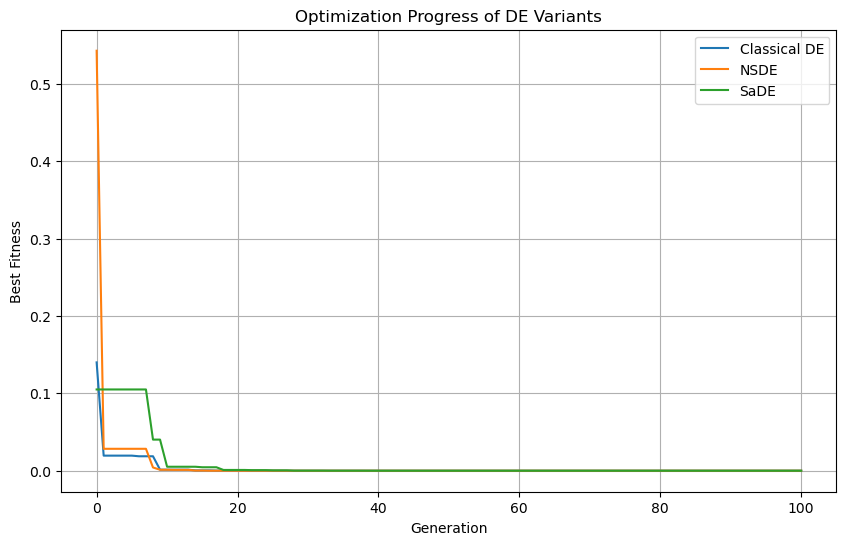

In [8]:
import random
import matplotlib.pyplot as plt

# Objective function for testing (Sum of squares)
def objective_function(x):
    return sum([i ** 2 for i in x])

# Differential Evolution Algorithm (Classical DE) with plotting support
def differential_evolution(objective_func, bounds, max_iter=1000, population_size=50, F=0.8, CR=0.9):
    dim = len(bounds)
    population = []
    for _ in range(population_size):
        individual = [random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)]
        population.append(individual)

    fitness = [objective_func(ind) for ind in population]

    best_idx = fitness.index(min(fitness))
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]

    # Store best fitness at each generation
    best_fitness_values = [best_fitness]

    for generation in range(max_iter):
        for i in range(population_size):
            # Mutation: Create a mutant vector
            idxs = list(range(population_size))
            idxs.remove(i)  # Ensure no self-selection
            selected = random.sample(idxs, 3)
            p1, p2, p3 = population[selected[0]], population[selected[1]], population[selected[2]]

            mutant = [p1[j] + F * (p2[j] - p3[j]) for j in range(dim)]

            # Crossover: Generate a trial vector
            trial = population[i][:]
            for j in range(dim):
                if random.random() < CR:
                    trial[j] = mutant[j]

            # Selection: Choose the better solution
            trial_fitness = objective_func(trial)
            if trial_fitness < fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness

        # Update best solution found so far
        current_best_idx = fitness.index(min(fitness))
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]

        # Store the best fitness value of this generation
        best_fitness_values.append(best_fitness)

    return best_solution, best_fitness, best_fitness_values

# NSDE (Neighborhood Search DE) with plotting support
def nsde(objective_func, bounds, max_iter=1000, population_size=50, F=0.8, CR=0.9):
    dim = len(bounds)
    population = []
    for _ in range(population_size):
        individual = [random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)]
        population.append(individual)

    fitness = [objective_func(ind) for ind in population]

    best_idx = fitness.index(min(fitness))
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]

    # Store best fitness at each generation
    best_fitness_values = [best_fitness]

    for generation in range(max_iter):
        for i in range(population_size):
            # Mutation: Select three random individuals
            idxs = list(range(population_size))
            idxs.remove(i)
            selected = random.sample(idxs, 3)
            p1, p2, p3 = population[selected[0]], population[selected[1]], population[selected[2]]

            d = [p2[j] - p3[j] for j in range(dim)]  # Difference vector
            mutation = [p1[j] + random.gauss(0.5, 0.5) * d[j] if random.random() < 0.5 else p1[j] + F * d[j] for j in range(dim)]

            # Crossover: Generate a trial vector
            trial = population[i][:]
            for j in range(dim):
                if random.random() < CR:
                    trial[j] = mutation[j]

            # Selection: Choose the better solution
            trial_fitness = objective_func(trial)
            if trial_fitness < fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness

        # Update best solution found so far
        current_best_idx = fitness.index(min(fitness))
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]

        # Store the best fitness value of this generation
        best_fitness_values.append(best_fitness)

    return best_solution, best_fitness, best_fitness_values

# SaDE (Self-Adaptive Differential Evolution) with plotting support
def sade(objective_func, bounds, max_iter=1000, population_size=50):
    dim = len(bounds)
    population = []
    for _ in range(population_size):
        individual = [random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)]
        population.append(individual)

    fitness = [objective_func(ind) for ind in population]

    best_idx = fitness.index(min(fitness))
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]

    CR_m = 0.5  # Initial crossover rate
    p = 0.5     # Probability for mutation strategy selection

    best_fitness_values = [best_fitness]

    for generation in range(max_iter):
        ns1, ns2 = 0, 0  # counters for successful offspring
        nf1, nf2 = 0, 0  # counters for discarded offspring

        for i in range(population_size):
            idxs = list(range(population_size))
            idxs.remove(i)
            selected = random.sample(idxs, 3)
            p1, p2, p3 = population[selected[0]], population[selected[1]], population[selected[2]]

            if random.random() < p:
                mutation = [p1[j] + F * (p2[j] - p3[j]) for j in range(dim)]
                ns1 += 1
            else:
                mutation = [p1[j] + F * (p1[j] - p2[j]) + F * (p2[j] - p3[j]) for j in range(dim)]
                ns2 += 1

            trial = population[i][:]
            for j in range(dim):
                if random.random() < CR_m:
                    trial[j] = mutation[j]

            trial_fitness = objective_func(trial)
            if trial_fitness < fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness
                if trial_fitness < best_fitness:
                    best_solution = trial
                    best_fitness = trial_fitness
            else:
                nf1 += 1 if random.random() < p else nf2

        p = ns1 / (ns1 + nf1)
        CR_m = 0.5 + 0.1 * random.gauss(0.5, 0.3)

        best_fitness_values.append(best_fitness)

    return best_solution, best_fitness, best_fitness_values

# Set problem bounds and run DE
bounds = [(-5, 5), (-5, 5)]  # 2D problem space
max_iter = 100
population_size = 50

# Run classical DE
solution, fitness, de_fitness_values = differential_evolution(objective_function, bounds, max_iter, population_size)
print("Classical DE Solution:", solution, "Fitness:", fitness)

# Run NSDE
solution_nsde, fitness_nsde, nsde_fitness_values = nsde(objective_function, bounds, max_iter, population_size)
print("NSDE Solution:", solution_nsde, "Fitness:", fitness_nsde)

# Run SaDE
solution_sade, fitness_sade, sade_fitness_values = sade(objective_function, bounds, max_iter, population_size)
print("SaDE Solution:", solution_sade, "Fitness:", fitness_sade)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(de_fitness_values, label="Classical DE")
plt.plot(nsde_fitness_values, label="NSDE")
plt.plot(sade_fitness_values, label="SaDE")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Optimization Progress of DE Variants")
plt.legend()
plt.grid(True)
plt.show()


##  Ant Colony Optimization

Ant Colony Optimization (ACO) is a nature-inspired metaheuristic optimization algorithm that is based on the foraging behavior of ants in nature. This algorithm falls under the category of swarm intelligence, which is a type of problem-solving technique that leverages the collective behavior of decentralized systems. Swarm intelligence involves simple agents interacting with each other to solve complex problems. 

### Real Ants and Artificial Ants

### Real Ants
In nature, ants exhibit simple behaviors and communicate indirectly using pheromones. Ants lay down pheromone trails on paths they travel, and other ants follow these trails. Over time, shorter paths accumulate more pheromone, and hence, are more likely to be chosen by other ants. This collective behavior leads ants to find the shortest path between their nest and a food source. The main features of real ants are:

- **Transition Rule**: Ants decide which food source to go to based on the distance to the source and the amount of pheromone on the path.
- **Tabu List**: Once an ant visits a food source, it adds it to a tabu list, preventing it from revisiting the same source.
- **Pheromone Deposit**: After completing a tour, an ant deposits pheromone on each path visited, reinforcing it for future ants to follow.

### Artificial Ants
Artificial ants are inspired by real ants and are used in optimization algorithms to solve complex problems. The key features of artificial ants are:

- **Search for Minimum Cost Solutions**: An artificial ant seeks to find the minimum cost feasible solution, which can be represented as $ \hat{\psi} = \min_{\psi} J(L, t) $.
- **Internal Memory**: Each artificial ant has a memory $ M_k $, which stores the path information it has traversed. This helps to build feasible solutions, evaluate solutions, and retrace paths.
- **Movement**: An artificial ant moves from node $ i $ to node $ j $ based on a transition rule, which considers pheromone levels, heuristic information, and the ant's internal memory.
- **Termination Condition**: The search stops when an ant satisfies a termination condition, such as reaching the target state or exceeding a maximum number of iterations.
- **Guidance Factors**: The movement of an artificial ant is governed by a probabilistic decision rule that uses pheromone levels, heuristics, and past history (stored in memory).

### Key Characteristics of Artificial Ants
1. **Probabilistic Path Preference**: Artificial ants prefer paths with higher pheromone concentrations, leading to a higher likelihood of revisiting shorter paths.
2. **Pheromone Growth on Shorter Paths**: Shorter paths accumulate more pheromone, reinforcing them for future ants.
3. **Indirect Communication**: Ants communicate indirectly by depositing pheromone on paths, which influences the decisions of other ants.

### Pheromone Update
Ants update the pheromone levels on the paths they traverse using two mechanisms:
1. **Step-by-Step Pheromone Update**: The pheromone trail is updated as the ant moves along the path.
2. **Delayed Pheromone Update**: After the ant completes the solution, it retraces its path and updates the pheromone levels accordingly.

### Termination
Once an ant completes a solution, it may retrace its path backward, updating the pheromone levels. The ant then "dies," freeing up the resources it used for the search.

---

### Summary
Ant Colony Optimization is a powerful optimization technique that mimics the foraging behavior of ants. The algorithm's strength lies in its ability to explore the search space using probabilistic decision-making influenced by pheromone levels, leading to the discovery of high-quality solutions to combinatorial and numerical optimization problems.


## Ant Colony Optimization

###  Mixed-Variable Optimization Problem

A **Mixed-Variable Optimization Problem (MVOP)** is a problem where the search space involves both discrete and continuous decision variables. The definition of the pheromone model for MVOP is as follows:

### Definition .38 (Mixed-Variable Optimization Problem [95])
A pheromone model $ R = (S, \mathcal{C}, f) $ of a mixed-variable optimization problem consists of the following parts:

- **Search Space $ S $**: The search space is defined over a finite set of both discrete and continuous decision variables and a set of constraints among these variables.
- **Objective Function $ f: S \to \mathbb{R}^+_0 $**: The function to be minimized. It maps the search space to non-negative real numbers.

Let $ S $ be the search space, which is defined by a set of $ n = d + r $ variables $ x_i $ for $ i = 1, \ldots, n $, where:
- $ d $ is the number of discrete decision variables,
- $ r $ is the number of continuous decision variables.

A solution $ s \in S $ is a complete value assignment, meaning each decision variable is assigned a value. A **feasible solution** is one that satisfies all constraints in the set $ \mathcal{C} $. A **global optimum** $ s^* \in S $ is a feasible solution satisfying:
$$
f(s^*) \leq f(s), \quad \forall s \in S.
$$
The set of all globally optimal solutions is denoted by $ S^* \subseteq S $.

### Solving the MVOP
Solving an MVOP requires finding at least one solution $ s^* \in S^* $.

---

##  Typical Ant Colony Optimization Problems

Ant Colony Optimization (ACO) is inspired by the foraging behavior of ants. In nature, ants use pheromones to communicate indirectly and collaboratively to find the shortest paths between their nest and a food source. Similarly, in ACO, artificial ants deposit pheromones on the graph of the problem they are solving. Each individual in the population is an artificial ant that builds a solution incrementally and stochastically.

The ACO algorithm involves three main components:

1. **Ant Solution Construct**: In the solution construction process, artificial ants move through adjacent states of a problem according to a transition rule, iteratively building solutions.
2. **Pheromone Update**: Pheromone trails are updated, either after a complete solution has been built or during each iteration.
3. **Daemon Actions**: An optional step that involves additional updates from a global perspective, such as reinforcing the best solution generated.

Below are three typical optimization problems where ACO is commonly applied:

### 1. Job Scheduling Problems (JSP)

Job scheduling problems play a significant role due to increasing consumer demand, product variety, and the rapid development of new technologies. The **Job Shop Scheduling Problem (JSSP)** is one of the most popular and challenging combinatorial optimization problems.

The job scheduling problem consists of the following components:
- A number of independent jobs that need to be scheduled.
- A number of heterogeneous machine candidates to perform the jobs.
- The workload of each job (e.g., number of instructions).
- The computing capacity of each machine.
- The ready time for each machine, indicating when it finishes previous tasks.
- The Expected Time to Compute (ETC) matrix, which contains the expected execution time for each job on each machine.

### 2. Data Mining

In data mining, particularly in classification tasks, ACO algorithms can be used to discover classification rules. A classification rule is usually expressed in the form:
$$
\text{IF} \ \langle \text{conditions} \rangle \ \text{THEN} \ \langle \text{class} \rangle
$$
Where:
- The **antecedent** (IF part) contains conditions usually connected by logical operators (AND).
- The **consequent** (THEN part) specifies the predicted class for cases that satisfy all conditions in the antecedent.

ACO is effective in searching for a good combination of terms (logical conditions) involving values of predictor attributes.

### 3. Network Coding Resource Minimization (NCRM)

The **Network Coding Resource Minimization (NCRM)** problem is an optimization problem in the field of network coding. Although all nodes in a network can perform coding, only a subset of coding-possible nodes is required to achieve a network coding-based multicast (NCM) with a desired data rate. The goal is to minimize coding operations within NCM.

EAs (Evolutionary Algorithms) are mainstream solutions for NCRM, but they may struggle with integrating local information or domain knowledge, which can degrade optimization performance. ACO algorithms, by contrast, "learn while optimizing" and are well-suited for the NCRM problem.

---

### Summary

Ant Colony Optimization (ACO) algorithms are inspired by the collective behavior of ants and are widely used in various optimization problems, including job scheduling, data mining, and network resource minimization. The core of ACO is based on the deposition of pheromone trails by ants to communicate indirectly, guiding other ants toward optimal solutions. ACO has proven effective in solving complex combinatorial optimization problems with large search spaces.


Best path: [0, 1, 2, 3, 4]
Best distance: 14.87048159266775


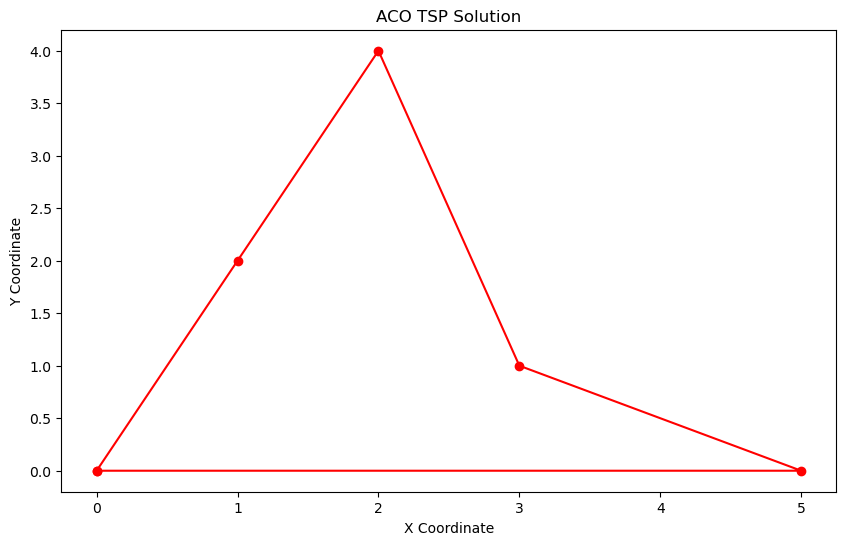

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Example TSP problem: Cities and distances between them
class ACO_TSP:
    def __init__(self, cities, n_ants, n_best, n_iterations, decay, alpha=1, beta=2):
        self.n_ants = n_ants  # Number of ants
        self.n_best = n_best  # Number of best ants to deposit pheromone
        self.n_iterations = n_iterations  # Number of iterations
        self.decay = decay  # Pheromone decay rate
        self.alpha = alpha  # Influence of pheromone on direction
        self.beta = beta  # Influence of distance on direction
        
        self.cities = cities  # Cities' coordinates
        self.distances = self.calculate_distances(cities)  # Distance matrix
        self.pheromone = np.ones(self.distances.shape)  # Initialize pheromone matrix
        self.best_distance = float('inf')  # Best distance found
        self.best_solution = None  # Best solution path

    def calculate_distances(self, cities):
        """Calculate the distance matrix for cities."""
        distances = np.zeros((len(cities), len(cities)))
        for i in range(len(cities)):
            for j in range(len(cities)):
                distances[i][j] = np.linalg.norm(np.array(cities[i]) - np.array(cities[j]))
        return distances

    def select_next_city(self, ant, visited):
        """Select the next city to visit using pheromone and distance."""
        current_city = ant[-1]
        probabilities = []
        for i in range(len(self.cities)):
            if i not in visited:
                pheromone = self.pheromone[current_city, i] ** self.alpha
                distance = self.distances[current_city, i] ** -self.beta
                probabilities.append(pheromone * distance)
            else:
                probabilities.append(0)
        total = sum(probabilities)
        probabilities = [prob / total for prob in probabilities]  # Normalize
        return random.choices(range(len(self.cities)), probabilities)[0]

    def update_pheromone(self, all_ants):
        """Update pheromones on the paths."""
        pheromone_update = np.zeros(self.pheromone.shape)
        for ant in all_ants:
            distance = self.calculate_total_distance(ant)
            for i in range(len(ant) - 1):
                pheromone_update[ant[i], ant[i+1]] += 1 / distance
        self.pheromone = (1 - self.decay) * self.pheromone + pheromone_update

    def calculate_total_distance(self, ant):
        """Calculate the total distance of a given solution (ant's path)."""
        distance = 0
        for i in range(len(ant) - 1):
            distance += self.distances[ant[i], ant[i+1]]
        distance += self.distances[ant[-1], ant[0]]  # Returning to the start
        return distance

    def run(self):
        """Run the Ant Colony Optimization algorithm."""
        for _ in range(self.n_iterations):
            all_ants = []
            for _ in range(self.n_ants):
                ant = [random.randint(0, len(self.cities)-1)]  # Start at a random city
                visited = set(ant)
                while len(ant) < len(self.cities):
                    next_city = self.select_next_city(ant, visited)
                    visited.add(next_city)
                    ant.append(next_city)
                all_ants.append(ant)

            # Update pheromone matrix based on the ants' solutions
            self.update_pheromone(all_ants)
            
            # Evaluate the best solution from the ants
            for ant in all_ants:
                distance = self.calculate_total_distance(ant)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = ant

        # Return the best solution found
        return self.best_solution, self.best_distance

    def plot_solution(self):
        """Plot the best solution path on a 2D plot."""
        x = [self.cities[i][0] for i in self.best_solution]
        y = [self.cities[i][1] for i in self.best_solution]
        x.append(x[0])  # to return to the starting city
        y.append(y[0])

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, 'o-', color='r')
        plt.title("ACO TSP Solution")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

# Example usage:
# Define 5 cities with their coordinates (x, y)
cities = [(0, 0), (1, 2), (2, 4), (3, 1), (5, 0)]

# Set up the ACO parameters
aco = ACO_TSP(cities, n_ants=10, n_best=3, n_iterations=100, decay=0.95)

# Run the ACO algorithm
best_solution, best_distance = aco.run()

# Display the best path and its distance
print("Best path:", best_solution)
print("Best distance:", best_distance)

# Plot the best solution
aco.plot_solution()


Best path: [3, 2, 1, 0, 4]
Best distance: 14.87048159266775


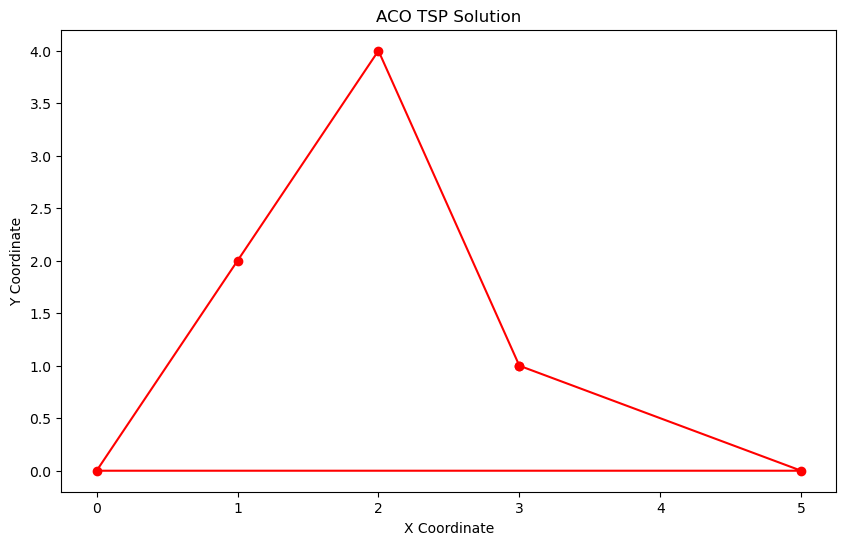

In [10]:
import random
import math
import matplotlib.pyplot as plt

# Example TSP problem: Cities and distances between them
class ACO_TSP:
    def __init__(self, cities, n_ants, n_best, n_iterations, decay, alpha=1, beta=2):
        self.n_ants = n_ants  # Number of ants
        self.n_best = n_best  # Number of best ants to deposit pheromone
        self.n_iterations = n_iterations  # Number of iterations
        self.decay = decay  # Pheromone decay rate
        self.alpha = alpha  # Influence of pheromone on direction
        self.beta = beta  # Influence of distance on direction
        
        self.cities = cities  # Cities' coordinates
        self.distances = self.calculate_distances(cities)  # Distance matrix
        self.pheromone = [[1 for _ in range(len(cities))] for _ in range(len(cities))]  # Initialize pheromone matrix
        self.best_distance = float('inf')  # Best distance found
        self.best_solution = None  # Best solution path

    def calculate_distances(self, cities):
        """Calculate the distance matrix for cities."""
        distances = [[0 for _ in range(len(cities))] for _ in range(len(cities))]
        for i in range(len(cities)):
            for j in range(len(cities)):
                if i != j:
                    distances[i][j] = math.sqrt((cities[i][0] - cities[j][0]) ** 2 + (cities[i][1] - cities[j][1]) ** 2)
        return distances

    def select_next_city(self, ant, visited):
        """Select the next city to visit using pheromone and distance."""
        current_city = ant[-1]
        probabilities = []
        for i in range(len(self.cities)):
            if i not in visited:
                pheromone = self.pheromone[current_city][i] ** self.alpha
                distance = self.distances[current_city][i] ** -self.beta
                probabilities.append(pheromone * distance)
            else:
                probabilities.append(0)
        total = sum(probabilities)
        probabilities = [prob / total for prob in probabilities]  # Normalize
        return random.choices(range(len(self.cities)), probabilities)[0]

    def update_pheromone(self, all_ants):
        """Update pheromones on the paths."""
        pheromone_update = [[0 for _ in range(len(self.cities))] for _ in range(len(self.cities))]
        for ant in all_ants:
            distance = self.calculate_total_distance(ant)
            for i in range(len(ant) - 1):
                pheromone_update[ant[i]][ant[i + 1]] += 1 / distance
        for i in range(len(self.pheromone)):
            for j in range(len(self.pheromone)):
                self.pheromone[i][j] = (1 - self.decay) * self.pheromone[i][j] + pheromone_update[i][j]

    def calculate_total_distance(self, ant):
        """Calculate the total distance of a given solution (ant's path)."""
        distance = 0
        for i in range(len(ant) - 1):
            distance += self.distances[ant[i]][ant[i + 1]]
        distance += self.distances[ant[-1]][ant[0]]  # Returning to the start
        return distance

    def run(self):
        """Run the Ant Colony Optimization algorithm."""
        for _ in range(self.n_iterations):
            all_ants = []
            for _ in range(self.n_ants):
                ant = [random.randint(0, len(self.cities)-1)]  # Start at a random city
                visited = set(ant)
                while len(ant) < len(self.cities):
                    next_city = self.select_next_city(ant, visited)
                    visited.add(next_city)
                    ant.append(next_city)
                all_ants.append(ant)

            # Update pheromone matrix based on the ants' solutions
            self.update_pheromone(all_ants)
            
            # Evaluate the best solution from the ants
            for ant in all_ants:
                distance = self.calculate_total_distance(ant)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = ant

        # Return the best solution found
        return self.best_solution, self.best_distance

    def plot_solution(self):
        """Plot the best solution path on a 2D plot."""
        x = [self.cities[i][0] for i in self.best_solution]
        y = [self.cities[i][1] for i in self.best_solution]
        x.append(x[0])  # to return to the starting city
        y.append(y[0])

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, 'o-', color='r')
        plt.title("ACO TSP Solution")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

# Example usage:
# Define 5 cities with their coordinates (x, y)
cities = [(0, 0), (1, 2), (2, 4), (3, 1), (5, 0)]

# Set up the ACO parameters
aco = ACO_TSP(cities, n_ants=10, n_best=3, n_iterations=100, decay=0.95)

# Run the ACO algorithm
best_solution, best_distance = aco.run()

# Display the best path and its distance
print("Best path:", best_solution)
print("Best distance:", best_distance)

# Plot the best solution
aco.plot_solution()


Best path: [3, 2, 1, 0, 4]
Best distance: 14.87048159266775


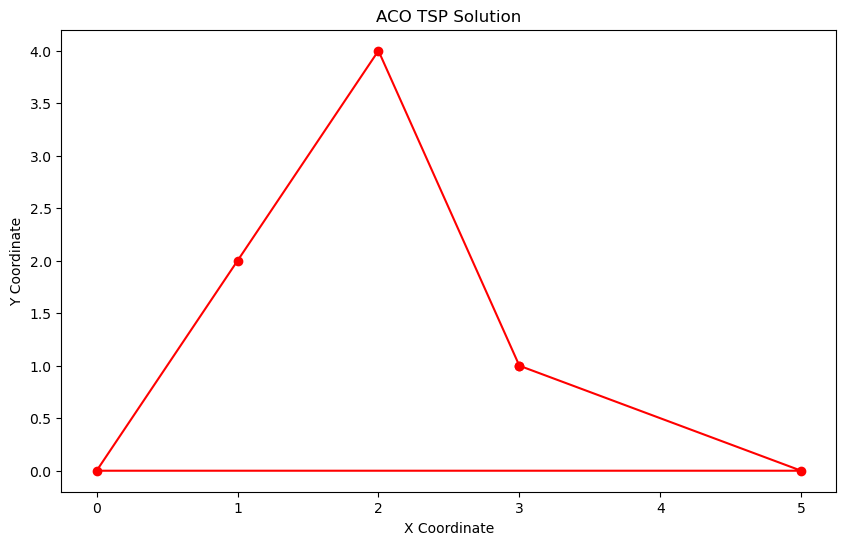

In [11]:
import random
import math
import matplotlib.pyplot as plt

# Example TSP problem: Cities and distances between them
class ACO_TSP:
    def __init__(self, cities, n_ants, n_best, n_iterations, decay, alpha=1, beta=2):
        self.n_ants = n_ants  # Number of ants
        self.n_best = n_best  # Number of best ants to deposit pheromone
        self.n_iterations = n_iterations  # Number of iterations
        self.decay = decay  # Pheromone decay rate
        self.alpha = alpha  # Influence of pheromone on direction
        self.beta = beta  # Influence of distance on direction
        
        self.cities = cities  # Cities' coordinates
        self.distances = self.calculate_distances(cities)  # Distance matrix
        self.pheromone = [[1 for _ in range(len(cities))] for _ in range(len(cities))]  # Initialize pheromone matrix
        self.best_distance = float('inf')  # Best distance found
        self.best_solution = None  # Best solution path

    def calculate_distances(self, cities):
        """Calculate the distance matrix for cities."""
        distances = [[0 for _ in range(len(cities))] for _ in range(len(cities))]
        for i in range(len(cities)):
            for j in range(len(cities)):
                if i != j:
                    distances[i][j] = math.sqrt((cities[i][0] - cities[j][0]) ** 2 + (cities[i][1] - cities[j][1]) ** 2)
        return distances

    def select_next_city(self, ant, visited):
        """Select the next city to visit using pheromone and distance."""
        current_city = ant[-1]
        probabilities = []
        for i in range(len(self.cities)):
            if i not in visited:
                pheromone = self.pheromone[current_city][i] ** self.alpha
                distance = self.distances[current_city][i] ** -self.beta
                probabilities.append(pheromone * distance)
            else:
                probabilities.append(0)
        total = sum(probabilities)
        probabilities = [prob / total for prob in probabilities]  # Normalize
        return random.choices(range(len(self.cities)), probabilities)[0]

    def update_pheromone(self, all_ants):
        """Update pheromones on the paths."""
        pheromone_update = [[0 for _ in range(len(self.cities))] for _ in range(len(self.cities))]
        for ant in all_ants:
            distance = self.calculate_total_distance(ant)
            for i in range(len(ant) - 1):
                pheromone_update[ant[i]][ant[i + 1]] += 1 / distance
        for i in range(len(self.pheromone)):
            for j in range(len(self.pheromone)):
                self.pheromone[i][j] = (1 - self.decay) * self.pheromone[i][j] + pheromone_update[i][j]

    def calculate_total_distance(self, ant):
        """Calculate the total distance of a given solution (ant's path)."""
        distance = 0
        for i in range(len(ant) - 1):
            distance += self.distances[ant[i]][ant[i + 1]]
        distance += self.distances[ant[-1]][ant[0]]  # Returning to the start
        return distance

    def run(self):
        """Run the Ant Colony Optimization algorithm."""
        for _ in range(self.n_iterations):
            all_ants = []
            for _ in range(self.n_ants):
                ant = [random.randint(0, len(self.cities)-1)]  # Start at a random city
                visited = set(ant)
                while len(ant) < len(self.cities):
                    next_city = self.select_next_city(ant, visited)
                    visited.add(next_city)
                    ant.append(next_city)
                all_ants.append(ant)

            # Update pheromone matrix based on the ants' solutions
            self.update_pheromone(all_ants)
            
            # Evaluate the best solution from the ants
            for ant in all_ants:
                distance = self.calculate_total_distance(ant)
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_solution = ant

        # Return the best solution found
        return self.best_solution, self.best_distance

    def plot_solution(self):
        """Plot the best solution path on a 2D plot."""
        x = [self.cities[i][0] for i in self.best_solution]
        y = [self.cities[i][1] for i in self.best_solution]
        x.append(x[0])  # to return to the starting city
        y.append(y[0])

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, 'o-', color='r')
        plt.title("ACO TSP Solution")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()

# Example usage:
# Define 5 cities with their coordinates (x, y)
cities = [(0, 0), (1, 2), (2, 4), (3, 1), (5, 0)]

# Set up the ACO parameters
aco = ACO_TSP(cities, n_ants=10, n_best=3, n_iterations=100, decay=0.95)

# Run the ACO algorithm
best_solution, best_distance = aco.run()

# Display the best path and its distance
print("Best path:", best_solution)
print("Best distance:", best_distance)

# Plot the best solution
aco.plot_solution()
